In [1]:
import argparse
import re
import networkx as nx
import scipy as scipy
import matplotlib.pyplot as plt # for visualizing GMLs
%matplotlib inline

def custom_stringizer(value):
    """Convert a `value` to a Python literal in GML representation.
    Parameters
    ----------
    value : object
        The `value` to be converted to GML representation.
    Returns
    -------
    rep : string
        A double-quoted Python literal representing value. Unprintable
        characters are replaced by XML character references.
    Raises
    ------
    ValueError
        If `value` cannot be converted to GML.
    Notes
    -----
    `literal_stringizer` is largely the same as `repr` in terms of
    functionality but attempts prefix `unicode` and `bytes` literals with
    `u` and `b` to provide better interoperability of data generated by
    Python 2 and Python 3.
    The original value can be recovered using the
    :func:`networkx.readwrite.gml.literal_destringizer` function.
    """

    def stringize(value):
        string = ""
        if isinstance(value, (int, bool)) or value is None:
            if value is True:  # GML uses 1/0 for boolean values.
                string += str(1)
            elif value is False:
                string += str(0)
            else:
                string += str(value)
        elif isinstance(value, (float, complex, str, bytes)):
            string += repr(value)
        elif isinstance(value, list):
            first = True
            for item in value:
                if not first:
                    string += ';'
                else:
                    first = False
                string += stringize(item)
        elif isinstance(value, dict):
            first = True
            for key, value in value.items():
                if not first:
                    string += ';'
                else:
                    first = False
                stringize(key)
                string += ':'
                stringize(value)
        elif isinstance(value, set):
            first = True
            for item in value:
                if not first:
                    string += ';'
                else:
                    first = False
                string += stringize(item)
        else:
            raise ValueError('%r cannot be converted into a Python literal' %
                             (value,))
        
        return string

    return stringize(value)

def clean_genome(input_string):
    
    # address contig break issues
    input_string = re.sub(r'_-', '_ -', input_string)
    
    # more than one hyphen
    pattern = r'-{2,}'
    input_string = re.sub(pattern, '-', input_string)

    # hyphens on their own and leading
    pattern = r'^\s*-\s*'
    input_string = re.sub(pattern, '-', input_string)

    # hyphens on their own, remove with following space
    input_string = re.sub(r'-\s', '', input_string)

    # internal hyphens or contig breaks, add as space
    input_string = re.sub(r'(\d)-(\d)', ' -', input_string)
    input_string = re.sub(r'(\s)_(\d)', '_ ', input_string)
    input_string = re.sub(r'(\d)_(\s)', ' _', input_string)
    input_string = re.sub(r'_-(\d)', '_ -', input_string)

    # trailing hyphens
    input_string = re.sub(r'\s-\s*$', '', input_string)

    # address other contig break issues
    input_string = re.sub(r'-_', '_', input_string)

    input_string = input_string.strip()

    return input_string

def add_node(G, genome_idx, node_id, real=True):

    if node_id != "_":
        node_id = int(node_id)
        if not G.has_node(abs(node_id)):
            G.add_node(abs(node_id),
                       members_sim=set(),
                       total_sim=[])
            
        G.nodes[abs(node_id)]['members_sim'].add(genome_idx)
        G.nodes[abs(node_id)]['total_sim'].append(genome_idx)

def add_edge(G, genome_idx, u, v):

    if u != "_" and v != "_":
        u = int(u)
        v = int(v)
        u_strand = 1 if u >= 0 else 0
        v_strand = 1 if v >= 0 else 0

        # add in absolute order
        first = min(abs(u), abs(v))
        second = max(abs(u), abs(v))

        same_strand = 1 if u_strand == v_strand else 0
        
        if not G.has_edge(first, second):
            G.add_edge(first, second,
                            members_sim=set(),
                            strand_sim=[],
                            total_sim=[])
            
        G.edges[first, second]['members_sim'].add(genome_idx)
        G.edges[first, second]['total_sim'].append(genome_idx)
        G.edges[first, second]['strand_sim'].append(same_strand)

def main():
    sim_genomes = "jupyter_genomes/S_pneumoniae_AtB_All_held_in_train_genomes_for_model_N10.txt"
    #sim_genomes = "jupyter_genomes/S_pneumoniae_AtB_All_held_in_train_genomes_for_model_N1to5.txt"
    #sim_genomes = "jupyter_genomes/S_pneumoniae_AtB_All_held_in_train_genomes_for_model_N6to10.txt"

    # choose outpref based on desired graph
    outpref = "jupyter_genomes/graph_all_new.gml"
    #outpref = "jupyter_genomes/graph_sim0thru4.gml"
    #outpref = "jupyter_genomes/graph_sim5thru9.gml"

    sim_genome_list = []
    with open(sim_genomes, "r") as f1:
        
        while True:
            line = f1.readline()
            if not line:
                break
            line = line.rstrip()

            # don't need this since genomes tokenized right, but can't hurt
            line = clean_genome(line)

            sim_genome_list.append(line.split())
    
    G=nx.Graph()
    
    for index, genome in enumerate(sim_genome_list):
        #print(index)
        #print(genome)
        for i in range(len(genome) - 1):
            u, v = genome[i], genome [i + 1]

            # add nodes
            add_node(G, index, u)
            add_node(G, index, v)

            # add edges, encoding directionality
            add_edge(G, index, u, v)

    # allow writing of graph to file
    for edge in G.edges():
        G.edges[edge[0], edge[1]]['members_sim'] = ";".join([str(i) for i in G.edges[edge[0], edge[1]]['members_sim']])

        G.edges[edge[0], edge[1]]['total_sim'] = ";".join([str(i) for i in G.edges[edge[0], edge[1]]['total_sim']])

        G.edges[edge[0], edge[1]]['strand_sim'] = ";".join([str(i) for i in G.edges[edge[0], edge[1]]['strand_sim']])

    for node, node_data in G.nodes(data=True):
        G.nodes[node]['members_sim'] = ";".join([str(i) for i in node_data['members_sim']])

        G.nodes[node]['total_sim'] = ";".join([str(i) for i in node_data['total_sim']])

    nx.write_gml(G, outpref)

if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: 'jupyter_genomes/S_pneumoniae_AtB_All_held_in_train_genomes_for_model_N10.txt'

In [121]:
### merge genomes

# read in two graphs
sim_graph_04 = nx.read_gml("jupyter_genomes/graph_sim0thru4.gml")
sim_graph_59 = nx.read_gml("jupyter_genomes/graph_sim5thru9.gml")

# for adding to genome ids of second graph
n_genomes_basegraph = 5

# create merge graph

def main():

    merged_graph = sim_graph_04
    print("num nodes (before):", len(merged_graph.nodes))

    # merge the two sets of unique nodes into one set of unique nodes
    for node in sim_graph_59.nodes:
        if node != "_":
            # remove negative but keep as string (otherwise has_node thinks
            # that node name is the node index)
            node = int(node)
            node = abs(node)
            node = str(node)
            if merged_graph.has_node(node):
                
                merged_graph.nodes[node]['total_sim'] += ";"
                to_append = ";".join(str(int(num) + n_genomes_basegraph) for num in sim_graph_59.nodes[node]['total_sim'].split(";"))
                merged_graph.nodes[node]['total_sim'] += to_append

                #print("merged total (after):", merged_graph.nodes[node]['total_sim'])

                set_old = set(merged_graph.nodes[node]['members_sim']) - set(";")    
                set_to_add = set(sim_graph_59.nodes[node]['members_sim']) - set(";")
                set_add_reindexed = {str(int(num) + n_genomes_basegraph) for num in set_to_add}
                set_total = set_old | set_add_reindexed
                set_total_str = ";".join(set_total)
                merged_graph.nodes[node]['members_sim'] = set_total_str
                
                #print("merged members (after):", merged_graph.nodes[node]['members_sim'])
                
            if not merged_graph.has_node(node):
                merged_graph.add_node(node,
                members_sim=[],
                total_sim=[])

                #### REINDEX
                
                members_sim_unindexed = sim_graph_59.nodes[node]['members_sim']
                #print("members_sim_unindexed:", members_sim_unindexed)
                members_sim_indexed = ";".join(str(int(num) + n_genomes_basegraph) for num in members_sim_unindexed.split(";"))
                merged_graph.nodes[node]['members_sim'] = members_sim_indexed
                #print("members sim indexed", merged_graph.nodes[node]['members_sim'])

                total_sim_unindexed = sim_graph_59.nodes[node]['total_sim']
                #print("total_sim_unindexed:", total_sim_unindexed)
                total_sim_indexed = ";".join(str(int(num) + n_genomes_basegraph) for num in total_sim_unindexed.split(";"))
                merged_graph.nodes[node]['total_sim'] = total_sim_indexed
                #print("total_sim indexed:", merged_graph.nodes[node]['total_sim'])

    print("num nodes (after):", len(merged_graph.nodes))

    print("sim59 edges:", len(sim_graph_59.edges))
    print("num edges (before):", len(merged_graph.edges))

    # merge the two sets of edges into one set of edges,
    # removing duplicates (including those with different strandedness)

    for edge in sim_graph_59.edges:
        u = edge[0]
        v = edge[1]

        if u != "_" and v != "_":
            u = int(u)
            v = int(v)
        # add in absolute order
            first = min(abs(u), abs(v))
            second = max(abs(u), abs(v))

            # make strings (same reason as with nodes, bc otherwise they're interpreted as indexes)
            first = str(first)
            second = str(second)

            if merged_graph.has_edge(first, second):

                #print("merged edge existing:", merged_graph.edges[edge[0], edge[1]]['members_sim'])

                set_old = set(merged_graph.edges[edge[0], edge[1]]['members_sim']) - set(";")    
                set_to_add = set(sim_graph_59.edges[edge[0], edge[1]]['members_sim']) - set(";")
                set_add_reindexed = {str(int(num) + n_genomes_basegraph) for num in set_to_add}
                set_total = set_old | set_add_reindexed
                set_total_str = ";".join(set_total)
                merged_graph.edges[edge[0], edge[1]]['members_sim'] = set_total_str
                
                #print("merged edge updated:", merged_graph.edges[edge[0], edge[1]]['members_sim'])

                #print("merged edge total existing:", merged_graph.edges[edge[0], edge[1]]['total_sim'])

                merged_graph.edges[edge[0], edge[1]]['total_sim'] += ";"
                to_append = ";".join(str(int(num) + n_genomes_basegraph) for num in sim_graph_59.edges[edge[0], edge[1]]['total_sim'].split(";"))
                merged_graph.edges[edge[0], edge[1]]['total_sim'] += to_append
                
                #print("merged edge total updated:", merged_graph.edges[edge[0], edge[1]]['total_sim'])

                #print("strand sim before:", merged_graph.edges[edge[0], edge[1]]['strand_sim'])

                merged_graph.edges[edge[0], edge[1]]['strand_sim'] += ";"
                merged_graph.edges[edge[0], edge[1]]['strand_sim'] += sim_graph_59.edges[edge[0], edge[1]]['strand_sim']
                
                #print("strand sim after:", merged_graph.edges[edge[0], edge[1]]['strand_sim'])

            if not merged_graph.has_edge(first, second):
                merged_graph.add_edge(first, second,
                                members_sim = [],
                                strand_sim=[],
                                total_sim=[])

                ### REINDEX (strand doesn't need to be indexed)

                members_sim_unindexed = sim_graph_59.edges[edge[0], edge[1]]['members_sim']
                #print("members_sim_unindexed:", members_sim_unindexed)
                members_sim_indexed = ";".join(str(int(num) + n_genomes_basegraph) for num in members_sim_unindexed.split(";"))
                merged_graph.edges[edge[0], edge[1]]['members_sim'] = members_sim_indexed
                #print("members sim indexed", merged_graph.edges[edge[0], edge[1]]['members_sim'])

                total_sim_unindexed = sim_graph_59.edges[edge[0], edge[1]]['total_sim']
                #print("total_sim_unindexed:", members_sim_unindexed)
                total_sim_indexed = ";".join(str(int(num) + n_genomes_basegraph) for num in total_sim_unindexed.split(";"))
                merged_graph.edges[edge[0], edge[1]]['total_sim'] = total_sim_indexed
                #print("total_sim indexed:", merged_graph.edges[edge[0], edge[1]]['total_sim'])

                #print("strand sim before:", sim_graph_59.edges[edge[0], edge[1]]['strand_sim'])
                merged_graph.edges[edge[0], edge[1]]['strand_sim'] = sim_graph_59.edges[edge[0], edge[1]]['strand_sim']
                #print("strand sim after:", merged_graph.edges[edge[0], edge[1]]['strand_sim'])

    print("num edges (after):", len(merged_graph.edges))
    
    nx.write_gml(merged_graph, "jupyter_genomes/merged_graph.gml")

if __name__ == "__main__":
    main()

num nodes (before): 4412
num nodes (after): 5046
sim59 edges: 5042
num edges (before): 6387
num edges (after): 8026


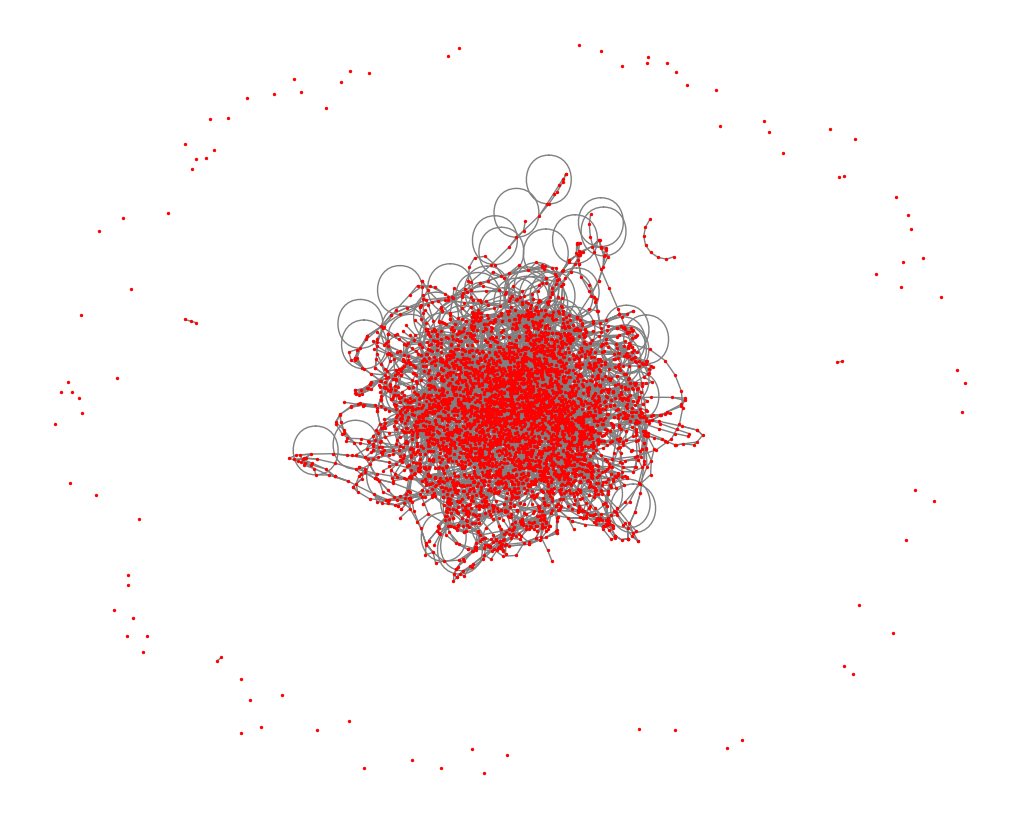

In [115]:
merged_graph = nx.read_gml("jupyter_genomes/merged_graph.gml")

plt.figure(figsize=(10, 8))  # Set the figure size
nx.draw(merged_graph, with_labels=False, node_color='red', edge_color='gray', node_size = 2)
plt.show()

In [ ]:
# Compare resulting graph to ground truth

# read in ground truth
sim_graph_all = nx.read_gml("jupyter_genomes/graph_all.gml")

#nx.is_isomorphic(merged_graph, sim_graph_all)

#ged_value = next(nx.optimize_graph_edit_distance(merged_graph, sim_graph_all))
#print(ged_value)

In [29]:
### nodes comparison

sim_graph_all = nx.read_gml("jupyter_genomes/graph_all.gml")

nodes_1 = sim_graph_04.nodes
print(len(nodes_1))
nodes_2 = sim_graph_59.nodes
print(len(nodes_2))

print("the graph_all has", len(sim_graph_all.nodes), "nodes")
print("the merged_graph has", len(merged_graph.nodes), "nodes")

### nodes comparison

nodes_merged = merged_graph.nodes
nodes_all = sim_graph_all.nodes

print(len(merged_graph.nodes))
print(len(sim_graph_all.nodes))

#print('no longer there:', set(nodes_all) - set(nodes_merged))
no_longer_there = set(nodes_all) - set(nodes_merged)

print(len(no_longer_there))

#print('newly added:', set(nodes_merged) - set(nodes_all))
newly_added = set(nodes_merged) - set(nodes_all)

print(len(newly_added))

### edges comparison

edges_merged = merged_graph.edges
edges_all = sim_graph_all.edges

print("merged edges", len(merged_graph.edges))
print("ground edges", len(sim_graph_all.edges))

#print('no longer there:', set(nodes_all) - set(nodes_merged))
no_longer_there = set(edges_all) - set(edges_merged)

print(len(no_longer_there))

#print('newly added:', set(nodes_merged) - set(nodes_all))
newly_added = set(edges_merged) - set(edges_all)

print(len(newly_added))

5046
3724
the graph_all has 5046 nodes


NameError: name 'merged_graph' is not defined

In [ ]:
# try compose method instead

#sim_new = sim_graph_04.update(sim_graph_59)

#sim_new = nx.compose(sim_graph_04, sim_graph_59)

#nx.is_isomorphic(sim_new, merged_graph)


In [ ]:
# merge the two sets of unique nodes into one set of unique nodes

def add_node(merged_graph, genome_idx, node_id):

    if node_id != "_":
        node_id = int(node_id)
        if not merged_graph.has_node(abs(node_id)):
            merged_graph.add_node(abs(node_id),
                       members_sim=set(),
                       total_sim=[])
        #merged_graph.nodes[abs(node_id)]['members_sim'].add(genome_idx)
        #merged_graph.nodes[abs(node_id)]['total_sim'].append(genome_idx)
        # maybe need to add an else statement to append with new members/total sim from other graph
        # even if node exists

In [ ]:
# merge the two sets of edges into one set of edges,
# removing duplicates (including those with different strandedness)

def add_edge(merged_graph, genome_idx, u, v):

        # add in absolute order
        first = min(abs(u), abs(v))
        second = max(abs(u), abs(v))
        
        if not merged_graph.has_edge(first, second):
            merged_graph.add_edge(first, second,
                            members_sim=set(),
                            strand_sim=[],
                            total_sim=[])
            
        merged_graph.edges[first, second]['members_sim'].add(genome_idx)
        merged_graph.edges[first, second]['total_sim'].append(genome_idx)
        merged_graph.edges[first, second]['strand_sim'].append(same_strand)

In [ ]:
import argparse
import re
import networkx as nx

def custom_stringizer(value):
    """Convert a `value` to a Python literal in GML representation.
    Parameters
    ----------
    value : object
        The `value` to be converted to GML representation.
    Returns
    -------
    rep : string
        A double-quoted Python literal representing value. Unprintable
        characters are replaced by XML character references.
    Raises
    ------
    ValueError
        If `value` cannot be converted to GML.
    Notes
    -----
    `literal_stringizer` is largely the same as `repr` in terms of
    functionality but attempts prefix `unicode` and `bytes` literals with
    `u` and `b` to provide better interoperability of data generated by
    Python 2 and Python 3.
    The original value can be recovered using the
    :func:`networkx.readwrite.gml.literal_destringizer` function.
    """

    def stringize(value):
        string = ""
        if isinstance(value, (int, bool)) or value is None:
            if value is True:  # GML uses 1/0 for boolean values.
                string += str(1)
            elif value is False:
                string += str(0)
            else:
                string += str(value)
        elif isinstance(value, (float, complex, str, bytes)):
            string += repr(value)
        elif isinstance(value, list):
            first = True
            for item in value:
                if not first:
                    string += ';'
                else:
                    first = False
                string += stringize(item)
        elif isinstance(value, dict):
            first = True
            for key, value in value.items():
                if not first:
                    string += ';'
                else:
                    first = False
                stringize(key)
                string += ':'
                stringize(value)
        elif isinstance(value, set):
            first = True
            for item in value:
                if not first:
                    string += ';'
                else:
                    first = False
                string += stringize(item)
        else:
            raise ValueError('%r cannot be converted into a Python literal' %
                             (value,))
        
        return string

    return stringize(value)

def get_options():
    description = "Compares synteny between simulated and generated genomes"
    parser = argparse.ArgumentParser(description=description,
                                        prog='python synteny_accuracy.py')
    IO = parser.add_argument_group('Input/options.out')
    IO.add_argument('--outpref',
                    default="comparisons",
                    help='Output prefix. Default = "comparisons"')
    IO.add_argument('--real',
                    required=True,
                    help='Path to real data .txt file.')
    IO.add_argument('--sim',
                    required=True,
                    help='Path to simulated data .txt file.')
    return parser.parse_args()

def clean_genome(input_string):
    
    # address contig break issues
    input_string = re.sub(r'_-', '_ -', input_string)
    
    # more than one hyphen
    pattern = r'-{2,}'
    input_string = re.sub(pattern, '-', input_string)

    # hyphens on their own and leading
    pattern = r'^\s*-\s*'
    input_string = re.sub(pattern, '-', input_string)

    # hyphens on their own, remove with following space
    input_string = re.sub(r'-\s', '', input_string)

    # internal hyphens or contig breaks, add as space
    input_string = re.sub(r'(\d)-(\d)', ' -', input_string)
    input_string = re.sub(r'(\s)_(\d)', '_ ', input_string)
    input_string = re.sub(r'(\d)_(\s)', ' _', input_string)
    input_string = re.sub(r'_-(\d)', '_ -', input_string)

    # trailing hyphens
    input_string = re.sub(r'\s-\s*$', '', input_string)

    # address other contig break issues
    input_string = re.sub(r'-_', '_', input_string)

    input_string = input_string.strip()

    return input_string

def add_node(G, genome_idx, node_id, real=True):

    if node_id != "_":
        node_id = int(node_id)
        if not G.has_node(abs(node_id)):
            G.add_node(abs(node_id),
                       members_real=set(),
                       members_sim=set(),
                       total_real=[],
                       total_sim=[])
    
        if real == True:
            G.nodes[abs(node_id)]['members_real'].add(genome_idx)
            G.nodes[abs(node_id)]['total_real'].append(genome_idx)
        else:
            G.nodes[abs(node_id)]['members_sim'].add(genome_idx)
            G.nodes[abs(node_id)]['total_sim'].append(genome_idx)

def add_edge(G, genome_idx, u, v, real=True):

    if u != "_" and v != "_":
        u = int(u)
        v = int(v)
        u_strand = 1 if u >= 0 else 0
        v_strand = 1 if v >= 0 else 0

        # add in absolute order
        first = min(abs(u), abs(v))
        second = max(abs(u), abs(v))


        same_strand = 1 if u_strand == v_strand else 0
        
        if not G.has_edge(first, second):
            G.add_edge(first, second, 
                            members_real=set(),
                            members_sim=set(),
                            strand_real=[],
                            strand_sim=[],
                            total_real=[],
                            total_sim=[])
        
        if real == True:
            G.edges[first, second]['members_real'].add(genome_idx)
            G.edges[first, second]['total_real'].append(genome_idx)
            G.edges[first, second]['strand_real'].append(same_strand)
        else:
            G.edges[first, second]['members_sim'].add(genome_idx)
            G.edges[first, second]['total_sim'].append(genome_idx)
            G.edges[first, second]['strand_sim'].append(same_strand)

def main():
    #options = get_options()
    #real_genomes = options.real
    #sim_genomes = options.sim
    #outpref = options.outpref

    real_genomes = "/home/shorsfield/software/panGPT/test_prompt.txt"
    sim_genomes = "/home/shorsfield/software/panGPT/simulations_temp_1.0_BPE_tokeniser.txt"
    outpref = "sim_test"

    real_genome_list = []
    with open(real_genomes, "r") as f1:
        while True:
            line = f1.readline()
            if not line:
                break
            line = line.rstrip()

            #print("Pre cleaning:")
            #print(line)
            line = clean_genome(line)

            #print("Post cleaning:")
            #print(line)

            real_genome_list.append(line.split())

    sim_genome_list = []
    with open(sim_genomes, "r") as f1:
        while True:
            line = f1.readline()
            if not line:
                break
            line = line.rstrip()

            #print("Pre cleaning:")
            #print(line)
            line = clean_genome(line)

            #print("Post cleaning:")
            #print(line)

            sim_genome_list.append(line.split())

    G=nx.Graph()
    real = True
    for index, genome in enumerate(real_genome_list):
        for i in range(len(genome) - 1):
            u, v = genome[i], genome [i + 1]

            # add nodes
            add_node(G, index, u, real=real)
            add_node(G, index, v, real=real)

            # add edges, encoding directionality
            add_edge(G, index, u, v, real=real)
    
    real = False
    for index, genome in enumerate(sim_genome_list):
        #print(index)
        #print(genome)
        for i in range(len(genome) - 1):
            u, v = genome[i], genome [i + 1]

            # add nodes
            add_node(G, index, u, real=real)
            add_node(G, index, v, real=real)

            # add edges, encoding directionality
            add_edge(G, index, u, v, real=real)

    # allow writing of graph to file
    for edge in G.edges():
        G.edges[edge[0], edge[1]]['members_sim'] = ";".join([str(i) for i in G.edges[edge[0], edge[1]]['members_sim']])
        G.edges[edge[0], edge[1]]['members_real'] = ";".join([str(i) for i in G.edges[edge[0], edge[1]]['members_real']])

        G.edges[edge[0], edge[1]]['total_sim'] = ";".join([str(i) for i in G.edges[edge[0], edge[1]]['total_sim']])
        G.edges[edge[0], edge[1]]['total_real'] = ";".join([str(i) for i in G.edges[edge[0], edge[1]]['total_real']])

        G.edges[edge[0], edge[1]]['strand_real'] = ";".join([str(i) for i in G.edges[edge[0], edge[1]]['strand_real']])
        G.edges[edge[0], edge[1]]['strand_sim'] = ";".join([str(i) for i in G.edges[edge[0], edge[1]]['strand_sim']])

    for node, node_data in G.nodes(data=True):
        G.nodes[node]['members_sim'] = ";".join([str(i) for i in node_data['members_sim']])
        G.nodes[node]['members_real'] = ";".join([str(i) for i in node_data['members_real']])

        G.nodes[node]['total_sim'] = ";".join([str(i) for i in node_data['total_sim']])
        G.nodes[node]['total_real'] = ";".join([str(i) for i in node_data['total_real']])

    nx.write_gml(G, outpref + '.gml')

if __name__ == "__main__":
    main()